In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import re
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews/Cell_Phones_and_Accessories_5.json


In [28]:
data = "/kaggle/input/amazon-reviews/Cell_Phones_and_Accessories_5.json"
df = pd.read_json(data, lines = True)

In [29]:
nltk.download('stopwords') 
# Get the list of English stop words
stop_words = set(stopwords.words('english'))
def remove_punctuation(text):
    if isinstance(text, str):
        translator = str.maketrans('', '', string.punctuation)
        text_without_punctuation = text.translate(translator)
        return text_without_punctuation
    else:
        return str(text) 
def remove_stopwords(text): 
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''
print("Done!")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Done!


In [30]:
df['reviewText'] = df['reviewText'].apply(remove_punctuation)
df['reviewText'] = df['reviewText'].apply(remove_stopwords)
df['reviewText'] = df['reviewText'].apply(lambda x: x.lower())
df['reviewText'].head()

0    look good stick good dont like rounded shape a...
1    stickers work like review says stick great sta...
2    awesome make phone look stylish used one far a...
3    item arrived great time perfect condition howe...
4    awesome stays looks great used multiple apple ...
Name: reviewText, dtype: object

In [31]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split()))

# Filter the DataFrame to keep only reviews with 15 or fewer words
    # After removing the stopwords
filtered_df = df[df['word_count'] <= 15]

# Drop the 'word_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['word_count'])

filtered_df.head()
rows = filtered_df.shape[0]
print(rows)

59905


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Feature extraction
vectorizer = TfidfVectorizer()  # You can adjust the max_features parameter
X = vectorizer.fit_transform(df['reviewText'])
y = df['overall']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a model
model = LogisticRegression() #All features

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6472947953096071
Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.55      0.57      2663
           2       0.31      0.12      0.18      2227
           3       0.40      0.29      0.34      4209
           4       0.46      0.30      0.36      7997
           5       0.73      0.91      0.81     21792

    accuracy                           0.65     38888
   macro avg       0.50      0.44      0.45     38888
weighted avg       0.60      0.65      0.61     38888



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


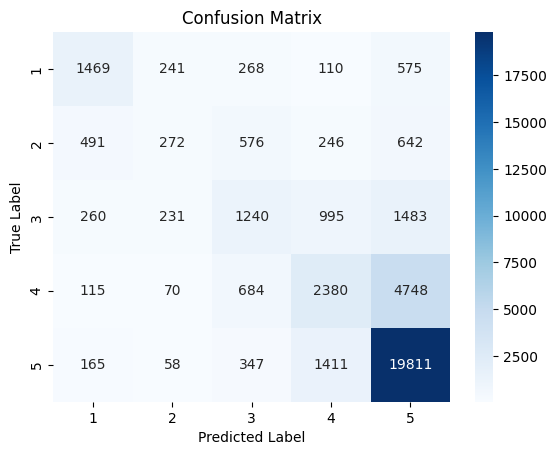

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
class_labels = [1, 2, 3, 4, 5]

y_pred = model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss

# Feature extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_df['reviewText'])
y = filtered_df['overall']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning function
def tune_random_forest(X_train, y_train, X_val, y_val, hyperparam_name, hyperparam_values):
    best_val_acc = 0
    best_hyperparam_value = None

    for hyperparam_value in hyperparam_values:
        rf_model = RandomForestClassifier(**{hyperparam_name: hyperparam_value}, random_state=5)
        rf_model.fit(X_train, y_train)

        y_train_pred_prob = rf_model.predict_proba(X_train)
        y_val_pred_prob = rf_model.predict_proba(X_val)

        train_loss = log_loss(y_train, y_train_pred_prob)
        val_loss = log_loss(y_val, y_val_pred_prob)

        train_acc = accuracy_score(y_train, rf_model.predict(X_train))
        val_acc = accuracy_score(y_val, rf_model.predict(X_val))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_hyperparam_value = hyperparam_value

    return best_hyperparam_value, best_val_acc

# Choose hyperparameter to tune and its values
hyperparam_name = 'n_estimators'
hyperparam_values = [50, 100, 150]  # Adjust values as needed

# Tune hyperparameter
best_n_estimators, best_val_accuracy = tune_random_forest(X_train, y_train, X_test, y_test, hyperparam_name, hyperparam_values)

# Train the model with the best hyperparameter
best_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy}")
print("Best Classification Report:\n", classification_report(y_test, y_pred))

Best Accuracy: 0.6500292129204573
Best Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.38      0.46       781
           2       0.40      0.01      0.02       633
           3       0.51      0.17      0.26      1287
           4       0.44      0.04      0.07      2004
           5       0.66      0.99      0.79      7276

    accuracy                           0.65     11981
   macro avg       0.52      0.32      0.32     11981
weighted avg       0.59      0.65      0.55     11981

